# Creating a data-backed playing field
Felix Zaussinger | 30.10.2020

## Core Analysis Goal(s)

1. Find LULC GIS layer and download data.
2. Downsampling to ~ 3 lower resolutions/larger cellsizes via rasterio.

## Key Insight(s)

1. The Historical and present land use dataset (downloaded 30.11.2020 at https://hlamap.org.uk/) useful for our purposes.

## Arising Todo(s)

1. Find forest inventory data and merge with HLA data to get the full picture.

#### Package imports

In [1]:
import os
import sys
sys.path.append('..')
import logging

%load_ext autoreload
%autoreload 2

import numpy as np
import rasterio
from pprint import pprint
from rasterio import features
from rasterio.plot import show

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import geopandas as gpd
import rasterio as rio

from src.gecm.dicts import nfi_mapping
from src.gecm.field import cmap2hex

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

#### Directory settings

In [2]:
data_raw = os.path.join("..", "data", "raw")
data_processed = os.path.join("..", "data", "processed")
figure_dir = os.path.join("..", "plots")

#### Define dimensions of output maps

In [3]:
# raster dims
rows = cols = 40

#### Whether optional, time-intensive tasks should be run

In [4]:
run_time_intensive_task = False

### Dataset 2: Park boundaries

In [5]:
parks_fpath = os.path.join(data_raw, "BIOSPH_SCOTLAND_ESRI", "BIOSPH_SCOTLAND.shp")
parks = gpd.read_file(parks_fpath)
our_park = parks.loc[parks.NAME == parks.NAME.unique()[0]]
our_park_polygon = our_park.dissolve(by="NAME")

<AxesSubplot:>

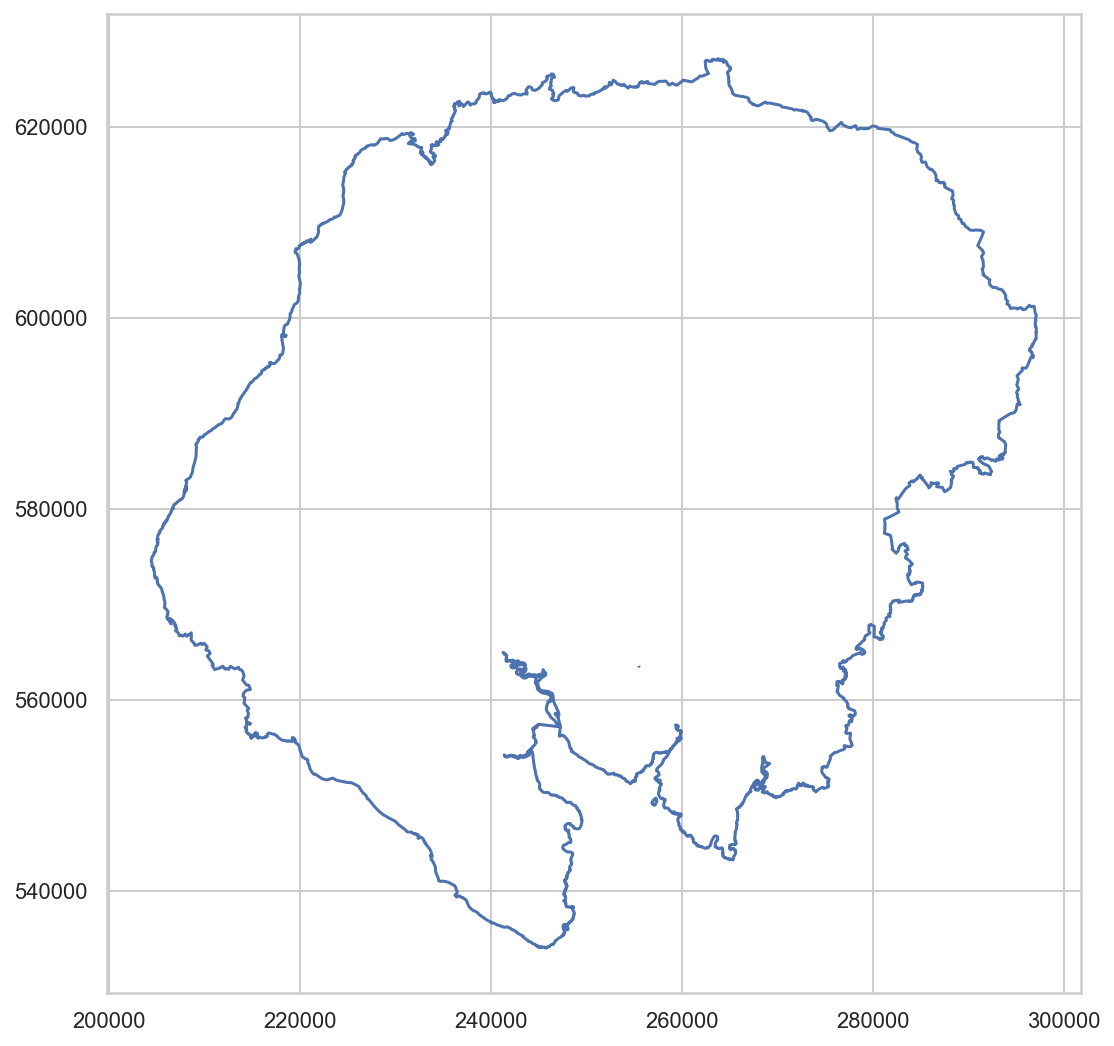

In [6]:
our_park_polygon.boundary.plot()

### Dataset 2: NFI woodland map 2018 
 
The NFI woodland map covers all forest and woodland area over 0.5 hectare with a minimum of 20% canopy cover (or the potential to achieve it) and a minimum width of 20 metres, including areas of new planting, clearfell, windblow and restocked areas.

**Category**             

1.            Woodland – areas greater than 0.5 hectares that represents the extent of mapped woodland

2.            Non woodland – open areas greater than 0.5 hectares completely surrounded by woodland



**Interpreted Forest Types (IFT) Woodland areas classification**

1.            Conifer - Coniferous woodland often occurs as large plantations with trees in regular rows and the stand edges may be regular and sharply defined. Some broadleaved trees may also be present but greater than 80% of the area will consist of conifers.

2.            Broadleaved - The canopy of broadleaved woodland is generally more uneven than that of coniferous woodland being made up of rounded crowns but with variations according to species, age, height, and season. Boundaries with adjacent internal polygons are generally less clearly defined than with conifers and naturally occurring stands may grade into adjacent ones with no sharp division. Some coniferous trees may be present but greater than 80% of the area will consist of broadleaved trees.

3.            Mixed Predominantly conifer - The interpretation of Mixed woodland can be very difficult as it exhibits intermediate characteristics between Conifer and Broadleaved woodland. There can be several types of mixed woodland. A plantation of alternate rows of conifer and broadleaves may produce a 'striped' appearance. You may see conifer and broadleaves planted in blocks, and there may be general intersperse woodland. The proportion of the Conifer will be more than 50% of the area and less than 80%.

4.            Mixed Predominantly broadleaved - The interpretation of Mixed woodland can be very difficult as it exhibits intermediate characteristics between Conifer and Broadleaved woodland. There can be several types of mixed woodland. A plantation of alternate rows of conifer and broadleaves may produce a 'striped' appearance. You may see conifer and broadleaves planted in blocks, and there may be general intersperse woodland. The proportion of the Broadleaves will be more than 50% of the area and less than 80%.

5.            Coppice - The most important characteristic of coppice areas on aerial photography is very even, smooth appearance. The coppice area may be made up of a patchwork of different ages (heights) but all show this very even character. Areas recently cut may appear to have a very clear floor with little felling debris.

6.            Coppice-with-Standards - Some areas of coppice also include larger broadleaved trees set in the coppice matrix. These broadleaved trees, often oak, are known as standards and show very clearly over the even coppice as large rounded crowns. The distribution of the standards may also be fairly scattered with approximately 25 per ha.

7.            Shrub - This category is intended to include areas that may possibly be woodland, where the growth is close to the ground and shows a rough character but no clear differentiation between Conifer and Broadleaved can yet be made. Areas being colonised by woody species may fall into this category. The cover will be at least 20%.

8.            Young Trees - Areas where planting is clearly visible but the trees cannot yet be allocated between Conifer and Broadleaved due to their immaturity. These areas can be on either land new to woodland or where a felled crop has been replaced.

9.            Felled - Areas of woodland where the trees have been harvested or felled. Stumps or felled trees may be visible and there may be long heaps of felling debris ('windrows'). Some standing trees within this limit may also be present but should be disregarded. The areas concerned may also have been re-stocked but the new trees are not yet visible.

10.          Ground Prepared for New Planting - Land in this category is area recently converted from some other land use to woodland and will show plough furrows or mounding but the new planting (if present) cannot yet be discerned

11.          Cloud or Shadow - If cloud or shadow areas obscure woodland detail and it is difficult to allocate one of the above IFTs, and then digitise a new boundary line feature around the area of uncertain forest type.

12.          Uncertain - Where the interpreter is uncertain of the IFT/IOA to be used X will be designated. The rate of use of this category should decline over time as operators become more proficient and better at recognising IFT/IOAs. As part of the QA procedures X's will be checked and operators found using this code frequently will be subject to more intensive QA procedures and possibly more training.

13.          Low density- This category intended to include areas that have less than 20% canopy cover that might have potential to achieve woodland in the future.  These areas will be monitored in future updates and either updated to reflect forest type or removed from the dataset.

14.          Assumed woodland - The supplied grant scheme and FC new planting polygons have been attributed as 'assumed woodland' as these areas have not been checked against the latest images and will be monitored in future updates and either updated to reflect forest type or removed from the dataset.

15.          Failed - Areas that show evidence of ground prep over several years and still exhibit no evidence of tress, based on the latest available imagery.

16.          Windblow - Areas of woodland where the trees have been uprooting or broken by the wind and which remain uncleared and not regenerated based on the latest available imagery.

**Non woodland areas classification**

1.            Open water - Normally labelled within OSMM, areas of even colour.

2.            Grass - A predominantly grassy area - may be agricultural or not.

3.            Agricultural land - May contain a cereal crop or pasture.

4.            Urban/Building - Buildings within woodland areas, may include gardens surrounding the building.

5.            Forest road, track - Linear feature, often fairly straight with gentle bends or turning circles.

6.            River - Linear feature, depending on location can be fairly straight or meander through woodland.

7.            Powerline - Possible shadow evidence of poles, pylons or even the cable/lines.

8.            Quarry - Show change in vegetation to geology, sand, slate, rock etc. Active quarries could have buildings, heavy plant tracks leading into the quarry.

9.            Bare - Bare ground/rock.

10.          Windfarm - Possible shadow evidence of turbines, normally in groups.

11.          Other vegetation - Not covered by the above, e.g. Gorse, Rhododendron, Bracken, Heather etc.


**Notes**

a.            Species such as Gorse and Rhododendron are not regarded as woodland and have therefore been excluded.

b.            Orchards are not regarded as woodland but have been mapped for carbon accounting purposes. Details can be provided on request.

c.             Interpreted Forest Types are only used to classify polygons in the NFI digital woodland map. IFTs are useful when using the map without the sample data, and for smaller geographic areas where the sample data would be inappropriate. However, for larger geographic areas data on forest types collected in the field is considered to be more accurate, and hence is used for reporting purposes.

#### Read simplified NFI file

In [7]:
nfi_inpath = os.path.join(data_processed, "NFI_valid_and_clipped.shp")

if os.path.exists(nfi_inpath):
    nfi_valid = gpd.read_file(nfi_inpath)

In [8]:
nfi_valid_clipped = gpd.clip(nfi_valid, our_park_polygon)

<AxesSubplot:>

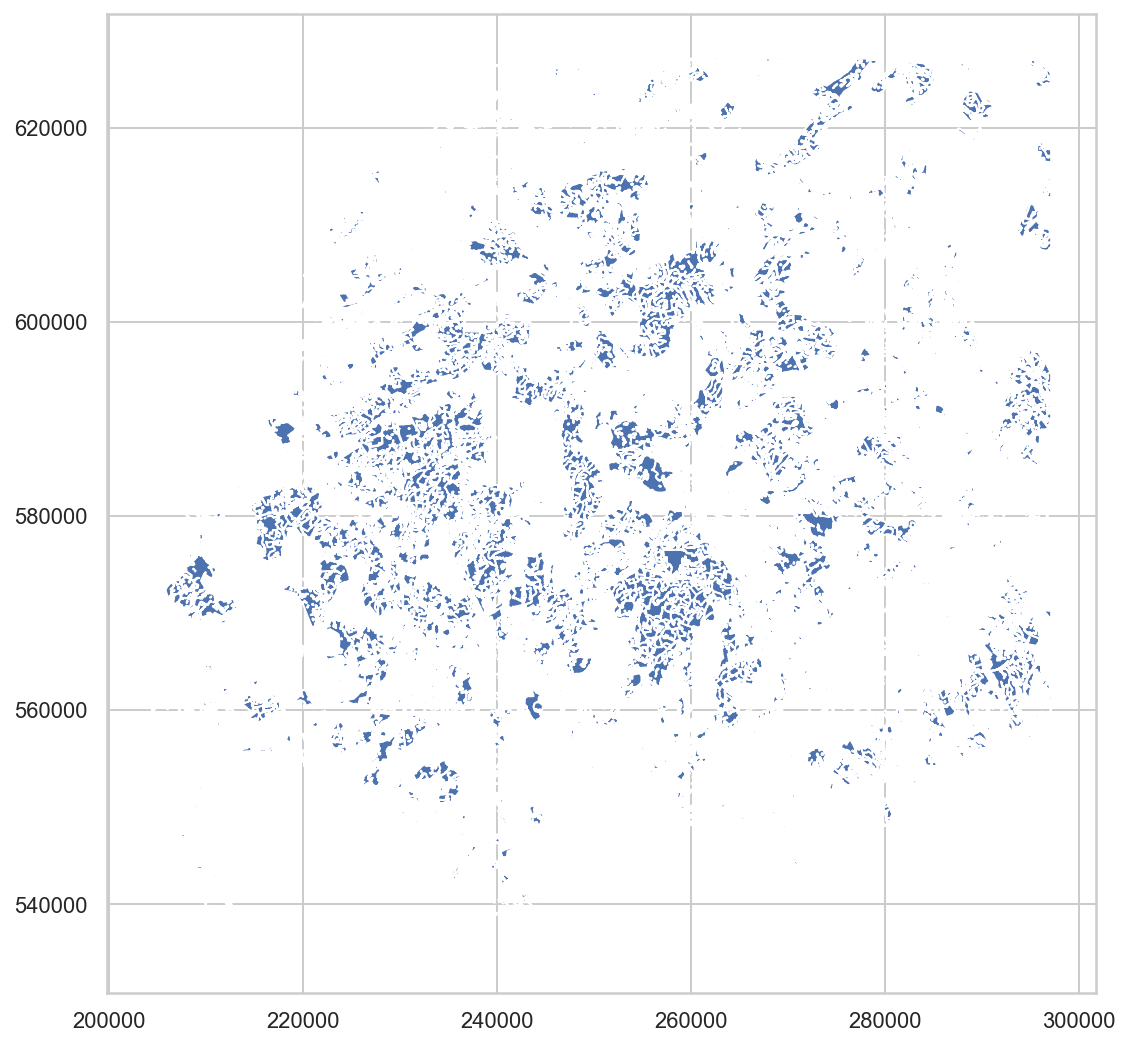

In [9]:
nfi_valid.plot()

<AxesSubplot:>

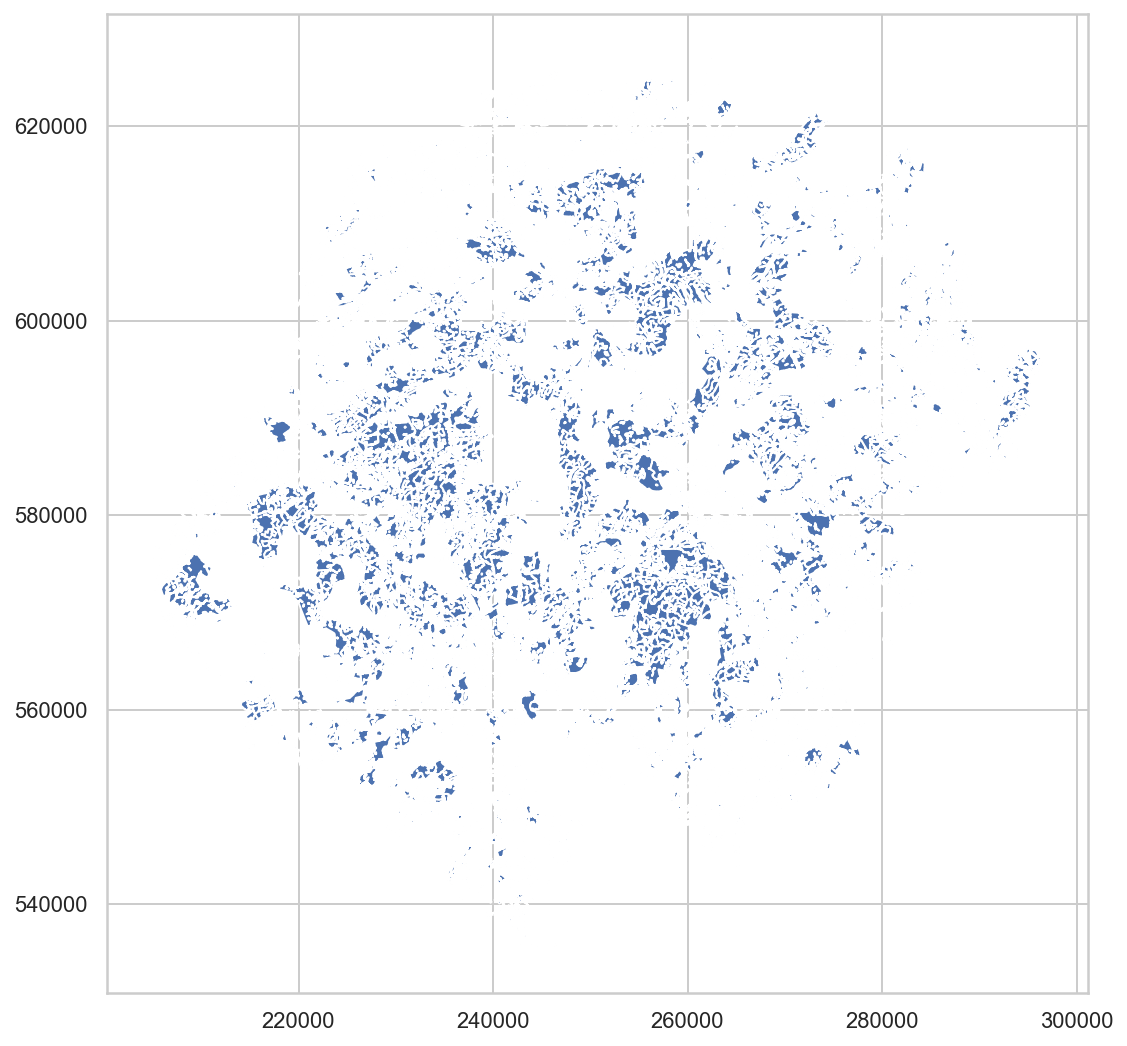

In [10]:
nfi_valid_clipped.plot()

In [11]:
if run_time_intensive_task:
    proportions = (nfi_valid_clipped.CATEGORY.value_counts() / nfi_valid_clipped.shape[0]) * 100
    proportions.plot.bar()

In [12]:
if run_time_intensive_task:
    ax = nfi_valid_clipped[nfi_valid_clipped.CATEGORY == "Woodland"].plot(color="green")
    nfi_valid_clipped[nfi_valid_clipped.CATEGORY == "Non woodland"].plot(ax=ax, color="black")

### Define colormap

In [13]:
n_categories = len(nfi_valid_clipped.IFT_IOA.unique())
cmap = plt.get_cmap("jet_r", lut=n_categories)

In [14]:
if run_time_intensive_task:

    ax = nfi_valid_clipped.plot(column="IFT_IOA", cmap=cmap, legend=True, categorical=True)
    our_park_polygon.boundary.plot(ax=ax, color="grey")

    plt.tight_layout()

    # save
    plt.savefig(
        os.path.join(figure_dir, "nfi_map_clipped_to_biosphere_v2.png"),
        dpi=150,
        format="png"
    )

In [15]:
if run_time_intensive_task:
    nfi_aggregates = nfi_valid_clipped.groupby("IFT_IOA").sum()
    nfi_aggregates["Shape__Are_percent"] = nfi_aggregates["Shape__Are"] / nfi_aggregates["Shape__Are"].sum()
    nfi_aggregates["Shape__Are_percent_of_all_area"] = nfi_aggregates["Shape__Are"] / our_park_polygon.area.values[0]
    assert nfi_aggregates["Shape__Are_percent"].sum() == 1

    nfi_aggregates["Shape__Are_percent_of_all_area"].plot.barh(color=cmap2hex(cmap))

    # save
    plt.savefig(
        os.path.join(figure_dir, "nfi_map_clipped_to_biosphere_v2_aggregates_all_area.png"),
        dpi=150,
        format="png"
    )

    1 - nfi_aggregates["Shape__Are_percent_of_all_area"].sum()

### Core assumption on LULC

Assign all remaining LULC (around 64 %) to grazing area. Spatial join?

In [16]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
# [MultiPolygon([feature]) if type(feature) == Polygon else feature for feature in nfi_valid_clipped["geometry"]]

In [17]:
mp = MultiPolygon(nfi_valid_clipped["geometry"].values)
d = {'id': ['biosphere'], 'geometry': [mp]}
nfi_valid_clipped_mp = gpd.GeoDataFrame(d, crs=nfi_valid_clipped.crs)

#### Method of spatial overlay
OP Methods: ‘intersection’, ‘union’, ‘identity’, ‘symmetric_difference’ or ‘difference’

-    intersects: The attributes will be joined if the boundary and interior of the object intersect in any way with the boundary and/or interior of the other object.

-    within: The attributes will be joined if the object’s boundary and interior intersect only with the interior of the other object (not its boundary or exterior).

-    contains: The attributes will be joined if the object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all.


In [18]:
sym_diff = gpd.overlay(our_park_polygon, nfi_valid_clipped_mp, how='difference')

<AxesSubplot:>

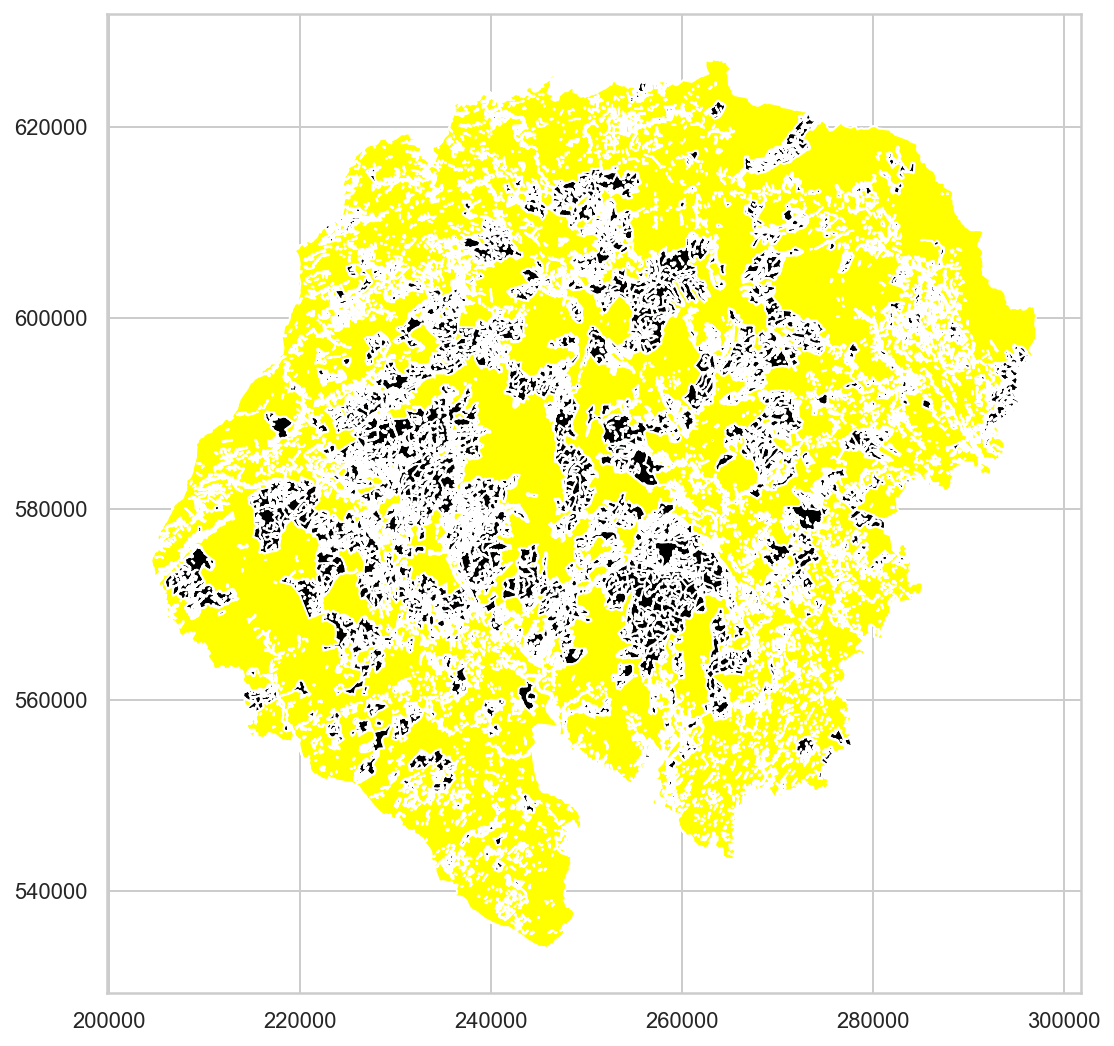

In [19]:
ax = nfi_valid_clipped_mp.plot(color="black")
sym_diff.plot(ax=ax, color="yellow")

In [20]:
nfi_valid_clipped.tail(1)

,OBJECTID_1,OBJECTID,CATEGORY,IFT_IOA,COUNTRY,Shape_Leng,Area_ha,Shape__Are,Shape__Len,geometry
22224,202778,613217,Woodland,Windblow,Scotland,303.765438,0.60294,6029.395508,303.765438,"POLYGON ((241414.034 573548.165, 241405.236 57..."


In [21]:
sym_diff = sym_diff.drop(columns=["PA_CODE", "STATUS", "SITE_HA"])

In [22]:
sym_diff.index.name = ""

In [23]:
sym_diff.index = [len(nfi_valid_clipped)]

In [24]:
sym_diff["OBJECTID_1"] = nfi_valid_clipped.iloc[-1, :].OBJECTID_1 + 1
sym_diff["OBJECTID"] = nfi_valid_clipped.iloc[-1, :].OBJECTID + 1
sym_diff["CATEGORY"] = "Non woodland"
sym_diff["IFT_IOA"] = "Grazing"
sym_diff["COUNTRY"] = "Scotland"
sym_diff["Shape__Are"] = sym_diff.area.values[0]

In [25]:
nfi_valid_clipped_final = pd.concat([nfi_valid_clipped, sym_diff], axis=0)

In [26]:
nfi_valid_clipped_final.tail()

,OBJECTID_1,OBJECTID,CATEGORY,IFT_IOA,COUNTRY,Shape_Leng,Area_ha,Shape__Are,Shape__Len,geometry
22213,198761,608852,Woodland,Windblow,Scotland,775.781535,2.673826,2.673826e+04,775.781535,"POLYGON ((272312.021 621133.724, 272339.802 62..."
22222,202767,613185,Woodland,Conifer,Scotland,82249.064441,1048.792329,1.048792e+07,82249.064441,"POLYGON ((240927.530 576750.219, 240927.377 57..."
22223,202777,613216,Woodland,Windblow,Scotland,1104.512784,3.614690,3.614690e+04,1104.512784,"POLYGON ((241140.500 573257.500, 241137.638 57..."
22224,202778,613217,Woodland,Windblow,Scotland,303.765438,0.602940,6.029396e+03,303.765438,"POLYGON ((241414.034 573548.165, 241405.236 57..."
17970,202779,613218,Non woodland,Grazing,Scotland,NaN,NaN,3.671109e+09,NaN,"MULTIPOLYGON (((263853.000 627063.000, 263906...."


#### Generate final plots 

In [27]:
n_categories = len(nfi_valid_clipped_final.IFT_IOA.unique())
cmap = plt.get_cmap("jet_r", lut=n_categories)

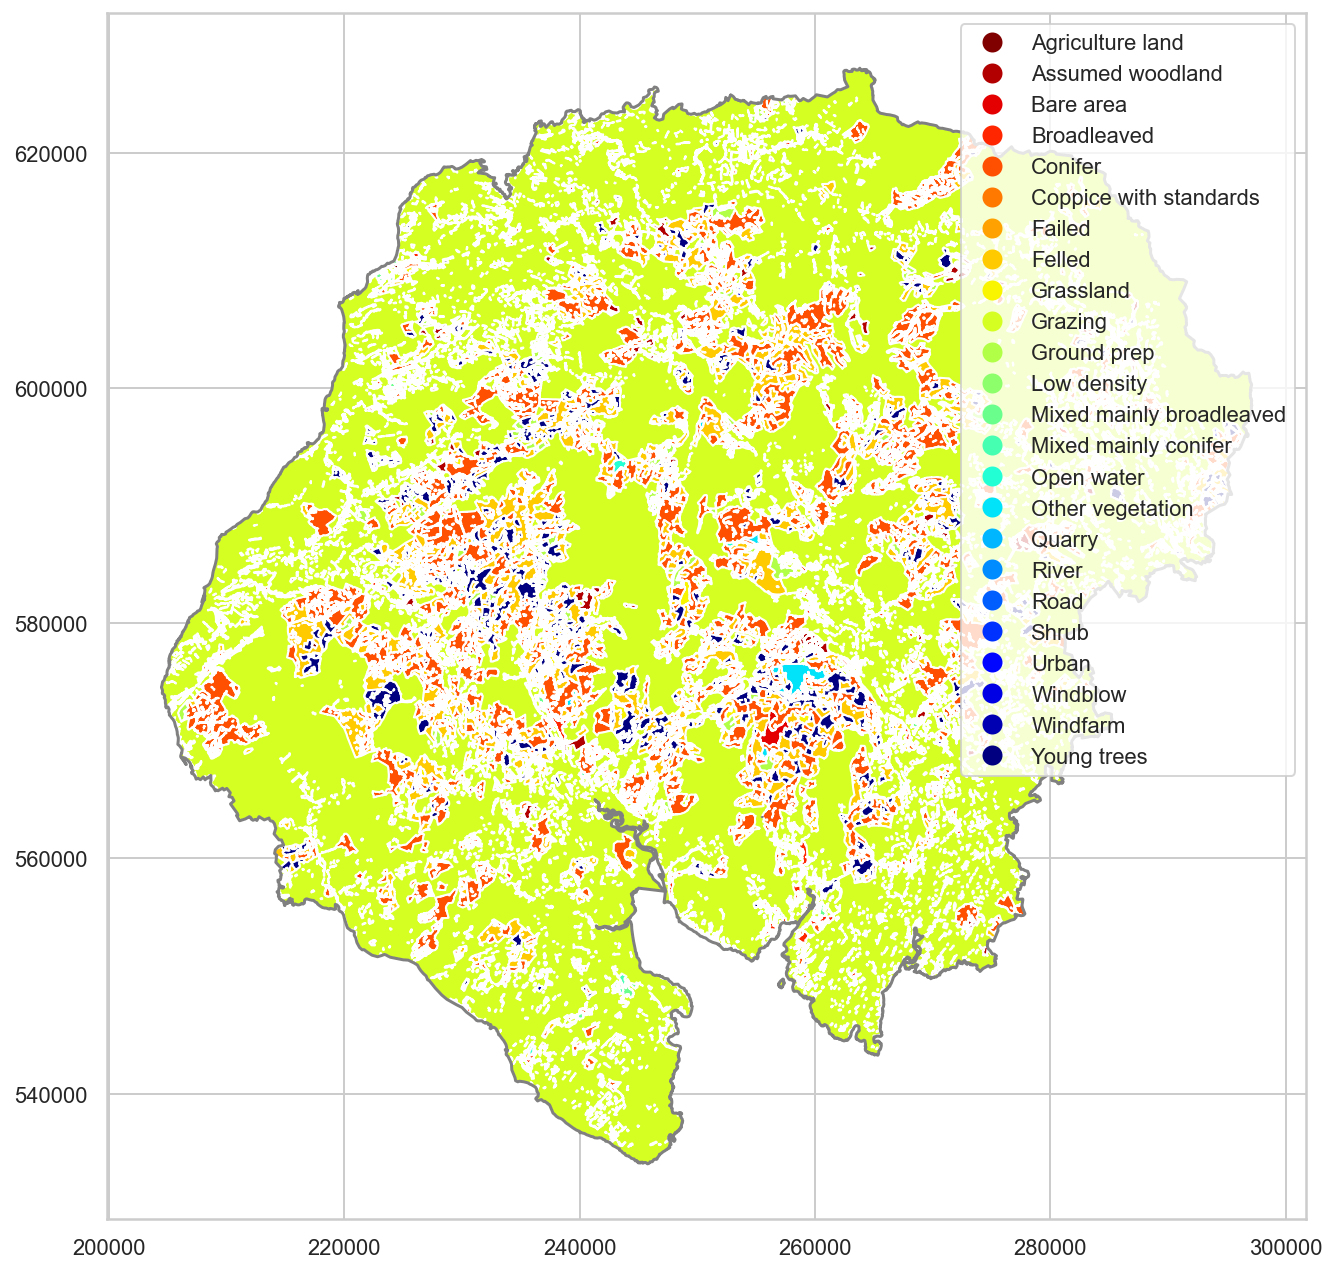

In [28]:
# Spatial plot
ax = nfi_valid_clipped_final.plot(column="IFT_IOA", cmap=cmap, legend=True, categorical=True)
our_park_polygon.boundary.plot(ax=ax, color="grey")

plt.tight_layout()

# save
plt.savefig(
    os.path.join(figure_dir, "nfi_map_clipped_to_biosphere_v2_final.png"),
    dpi=150,
    format="png"
)

In [29]:
nfi_aggregates_v2 = nfi_valid_clipped_final.groupby("IFT_IOA").sum()
nfi_aggregates_v2["Shape__Are_percent"] = nfi_aggregates_v2["Shape__Are"] / nfi_aggregates_v2["Shape__Are"].sum()
nfi_aggregates_v2["Shape__Are_percent_of_all_area"] = nfi_aggregates_v2["Shape__Are"] / our_park_polygon.area.values[0]
assert nfi_aggregates_v2["Shape__Are_percent"].sum() == 1

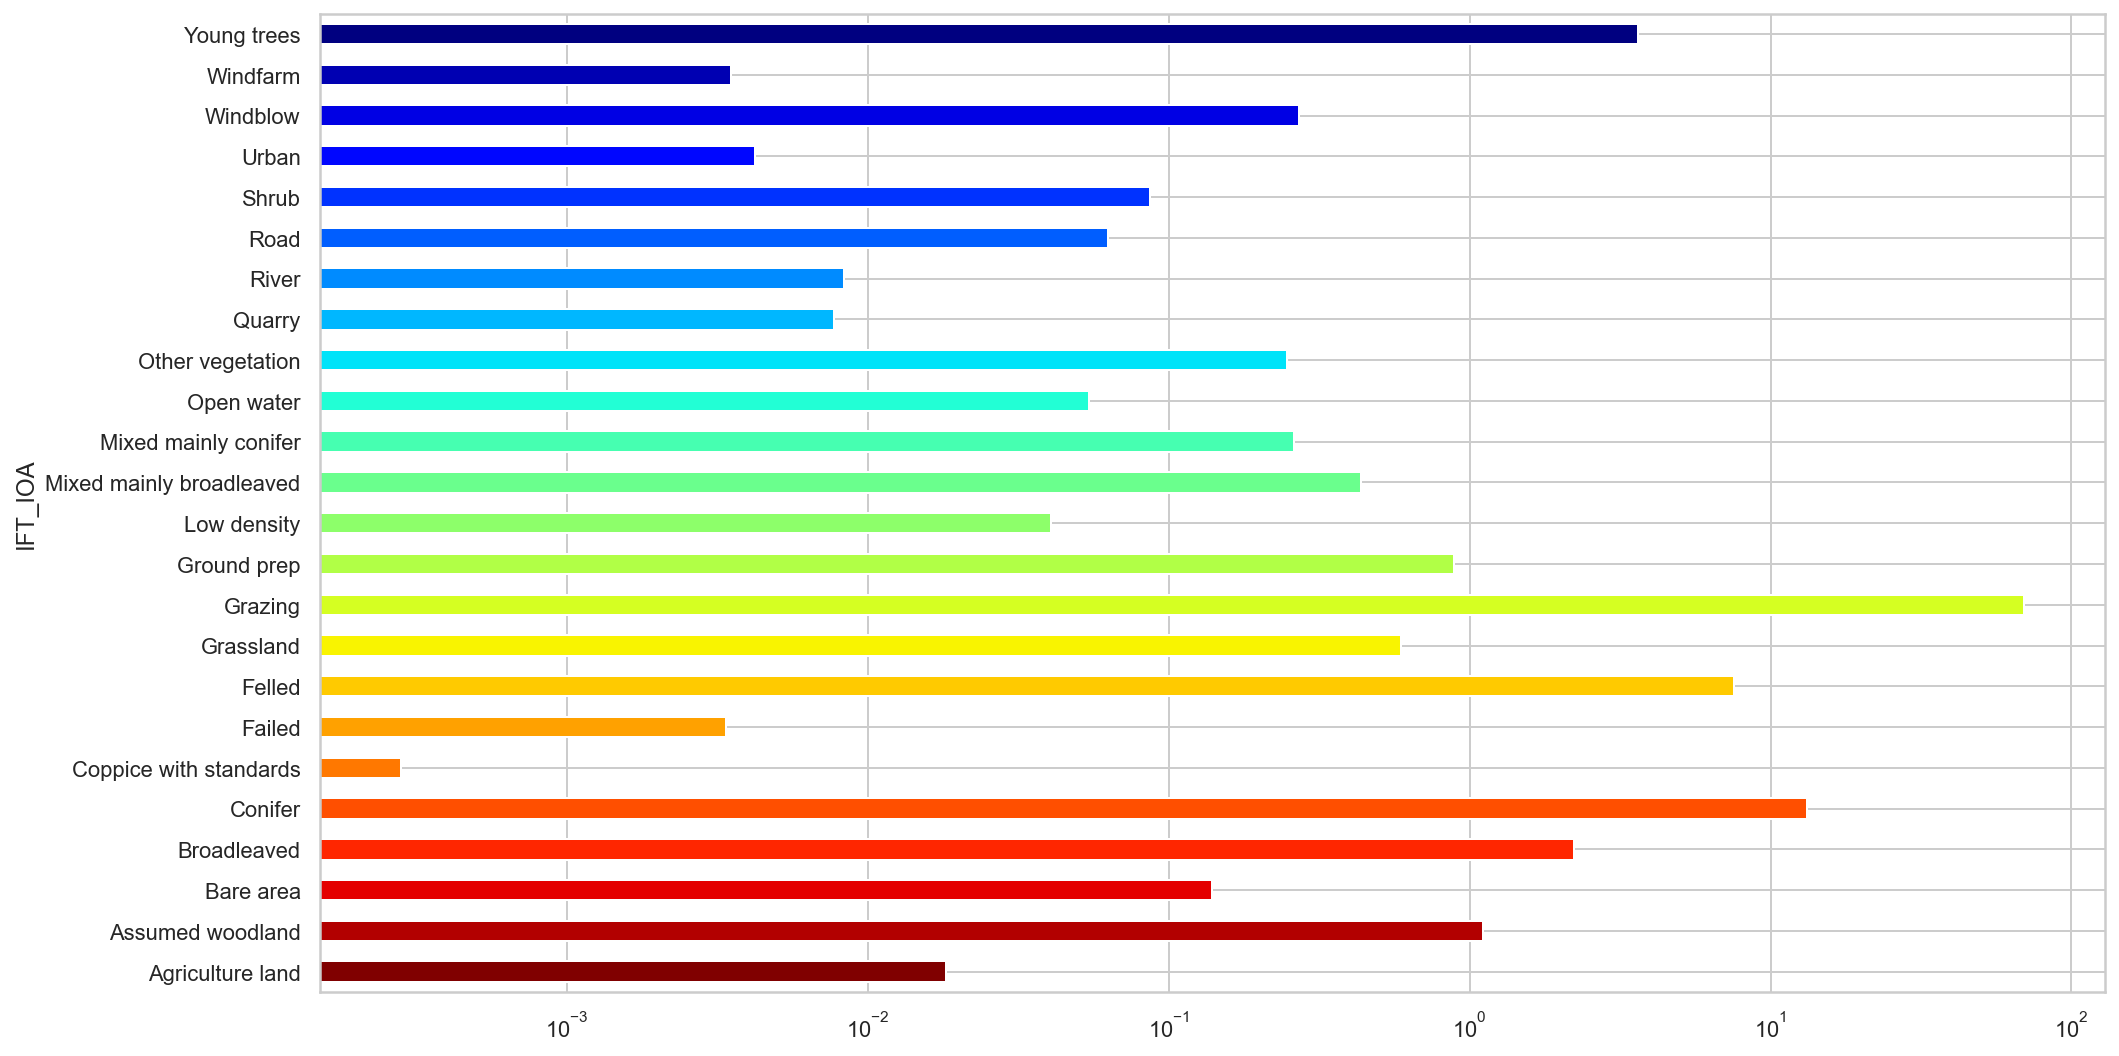

In [30]:
nfi_aggregates_v2["Shape__Are_percent_of_all_area"].multiply(100).plot.barh(color=cmap2hex(cmap), logx=True)

# save
plt.savefig(
    os.path.join(figure_dir, "nfi_map_clipped_to_biosphere_v2_final_logx.png"),
    dpi=150,
    format="png"
)

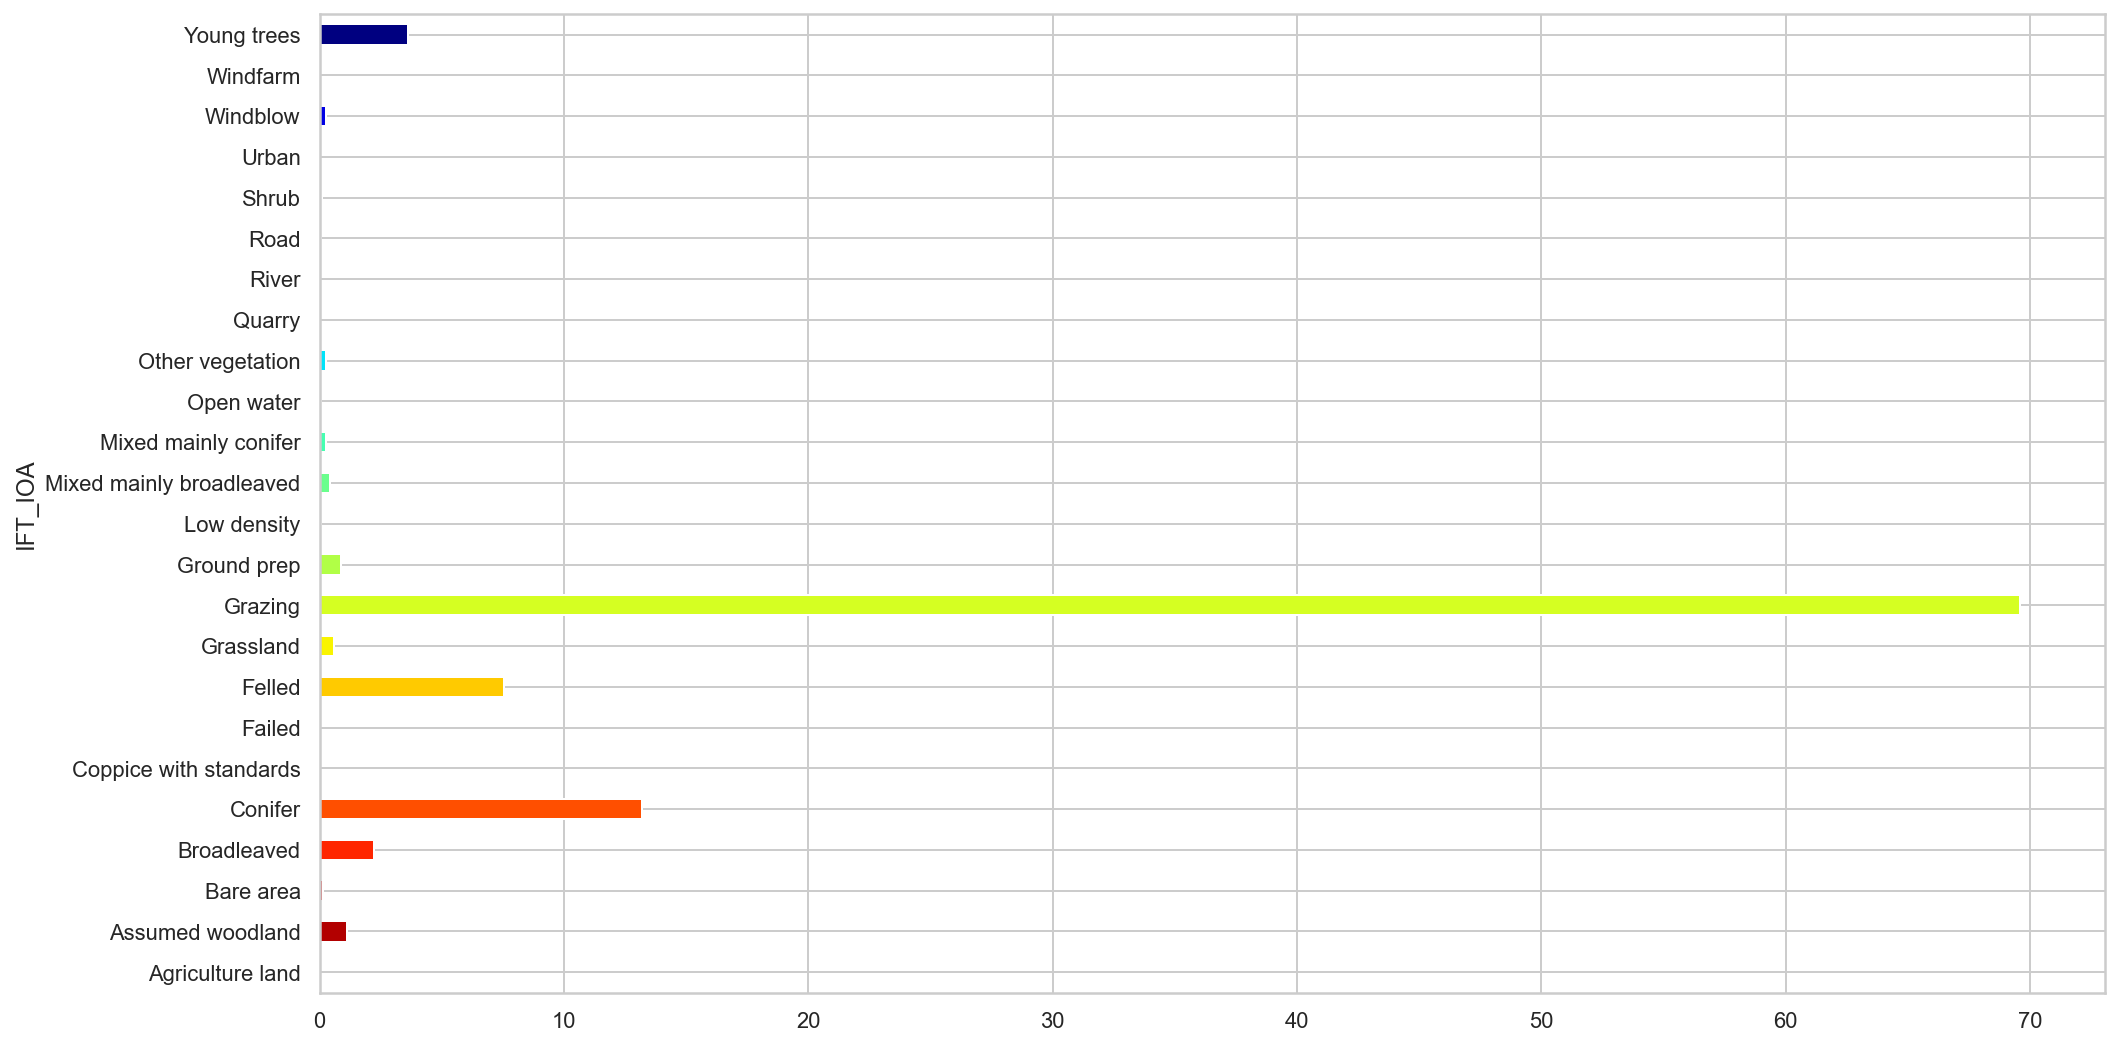

In [31]:
nfi_aggregates_v2["Shape__Are_percent_of_all_area"].multiply(100).plot.barh(color=cmap2hex(cmap), logx=False)

# save
plt.savefig(
    os.path.join(figure_dir, "nfi_map_clipped_to_biosphere_v2_final.png"),
    dpi=150,
    format="png"
)

Approach closes in on a 2 comma digit accuracy - awesome!

In [32]:
nfi_aggregates_v2["Shape__Are_percent_of_all_area"].sum()

1.0042500032452035

#### Convert NFI polygon's to raster (key piece of code)
Based on https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html

In [33]:
nfi_valid_clipped_final.head()

,OBJECTID_1,OBJECTID,CATEGORY,IFT_IOA,COUNTRY,Shape_Leng,Area_ha,Shape__Are,Shape__Len,geometry
0,2,883,Non woodland,Bare area,Scotland,1053.621578,3.357781,33577.814606,1053.621578,"POLYGON ((233732.700 549963.900, 233733.001 54..."
4,6,887,Non woodland,Bare area,Scotland,380.274117,0.831665,8316.648415,380.274117,"POLYGON ((235164.270 553569.222, 235170.598 55..."
5,7,888,Non woodland,Bare area,Scotland,418.164982,0.854268,8542.675835,418.164982,"POLYGON ((234131.899 553651.800, 234054.176 55..."
9,11,892,Non woodland,Bare area,Scotland,685.298683,0.720061,7200.609764,685.298683,"POLYGON ((227536.713 555385.128, 227543.816 55..."
10,12,893,Non woodland,Bare area,Scotland,984.407185,2.039442,20394.420593,984.407185,"POLYGON ((273071.062 555498.666, 273068.711 55..."


In [34]:
nfi_mapping

{'Conifer': 1,
 'Broadleaved': 2,
 'Mixed mainly conifer': 3,
 'Mixed mainly broadleaved': 4,
 'Coppice with standards': 6,
 'Shrub': 7,
 'Young trees': 8,
 'Felled': 9,
 'Ground prep': 10,
 'Low density': 13,
 'Assumed woodland': 14,
 'Failed': 15,
 'Windblow': 16,
 'Open water': 21,
 'Grassland': 22,
 'Agriculture land': 23,
 'Urban': 24,
 'Road': 25,
 'River': 26,
 'Quarry': 28,
 'Bare area': 29,
 'Windfarm': 210,
 'Other vegetation': 211,
 'Grazing': 240}

In [35]:
nfi_valid_clipped_final["IFT_IOA_num"] = [nfi_mapping[k] for k in nfi_valid_clipped_final.IFT_IOA.values]
nfi_valid_clipped_final["IFT_IOA_num"] = nfi_valid_clipped_final.IFT_IOA_num.astype("int16")

In [36]:
nfi_valid_clipped_final = nfi_valid_clipped_final.infer_objects()

In [39]:
# raster dims
rows = cols = 90

# 0) define geodataframe
gdf = nfi_valid_clipped_final

# 1) set bounds
# -----------------------------------------------------------------------------
bounds = our_park_polygon.convex_hull.envelope.bounds

# 2) define transform
coordinate_transform = rasterio.transform.from_bounds(
    west = bounds.minx.values[0], 
    south = bounds.miny.values[0], 
    east = bounds.maxx.values[0], 
    north = bounds.maxy.values[0], 
    width = cols, 
    height = rows
)

# 3) define path of output raster data
raster_fpath = os.path.join(data_processed, 'NFI_rasterized_{}_{}.tif'.format(rows, cols))

# 4) run burn-in algorithm
# -----------------------------------------------------------------------------
with rasterio.Env():
    
    # create array of (shape, value) tuples
    shapes = [(geom,value) for geom, value in zip(gdf.geometry.values, gdf.IFT_IOA_num.values)]
    
    # rasterize
    burned = features.rasterize(
        shapes=shapes, 
        out_shape=(rows, cols), 
        fill=255, 
        transform=coordinate_transform,
        all_touched=False
    )
    
    # value counts
    unique, counts = np.unique(burned, return_counts=True)
    pprint(np.asarray((unique, counts)).T)
    
    # count bands
    band_count = len(unique)
    
    # save as geotiff
    with rasterio.open(
            raster_fpath,
            'w+', # Open the file in read/write mode
            driver='GTiff',
            width=cols,
            height=rows,
            count=1,
            dtype=rasterio.uint8,
            nodata=255,
            transform=coordinate_transform,
            compress='lzw',
            crs={'init': "EPSG:4326"}) as out:
        
        # write bands
        out.write(burned.astype(rasterio.uint8), indexes=1)

array([[   1,  655],
       [   2,  103],
       [   3,   11],
       [   4,   26],
       [   7,    6],
       [   8,  203],
       [   9,  343],
       [  10,   39],
       [  13,    4],
       [  14,   50],
       [  16,   18],
       [  21,    2],
       [  22,   32],
       [  23,    2],
       [  24,    2],
       [  25,    4],
       [  29,    7],
       [ 211,   13],
       [ 240, 3435],
       [ 255, 3145]])


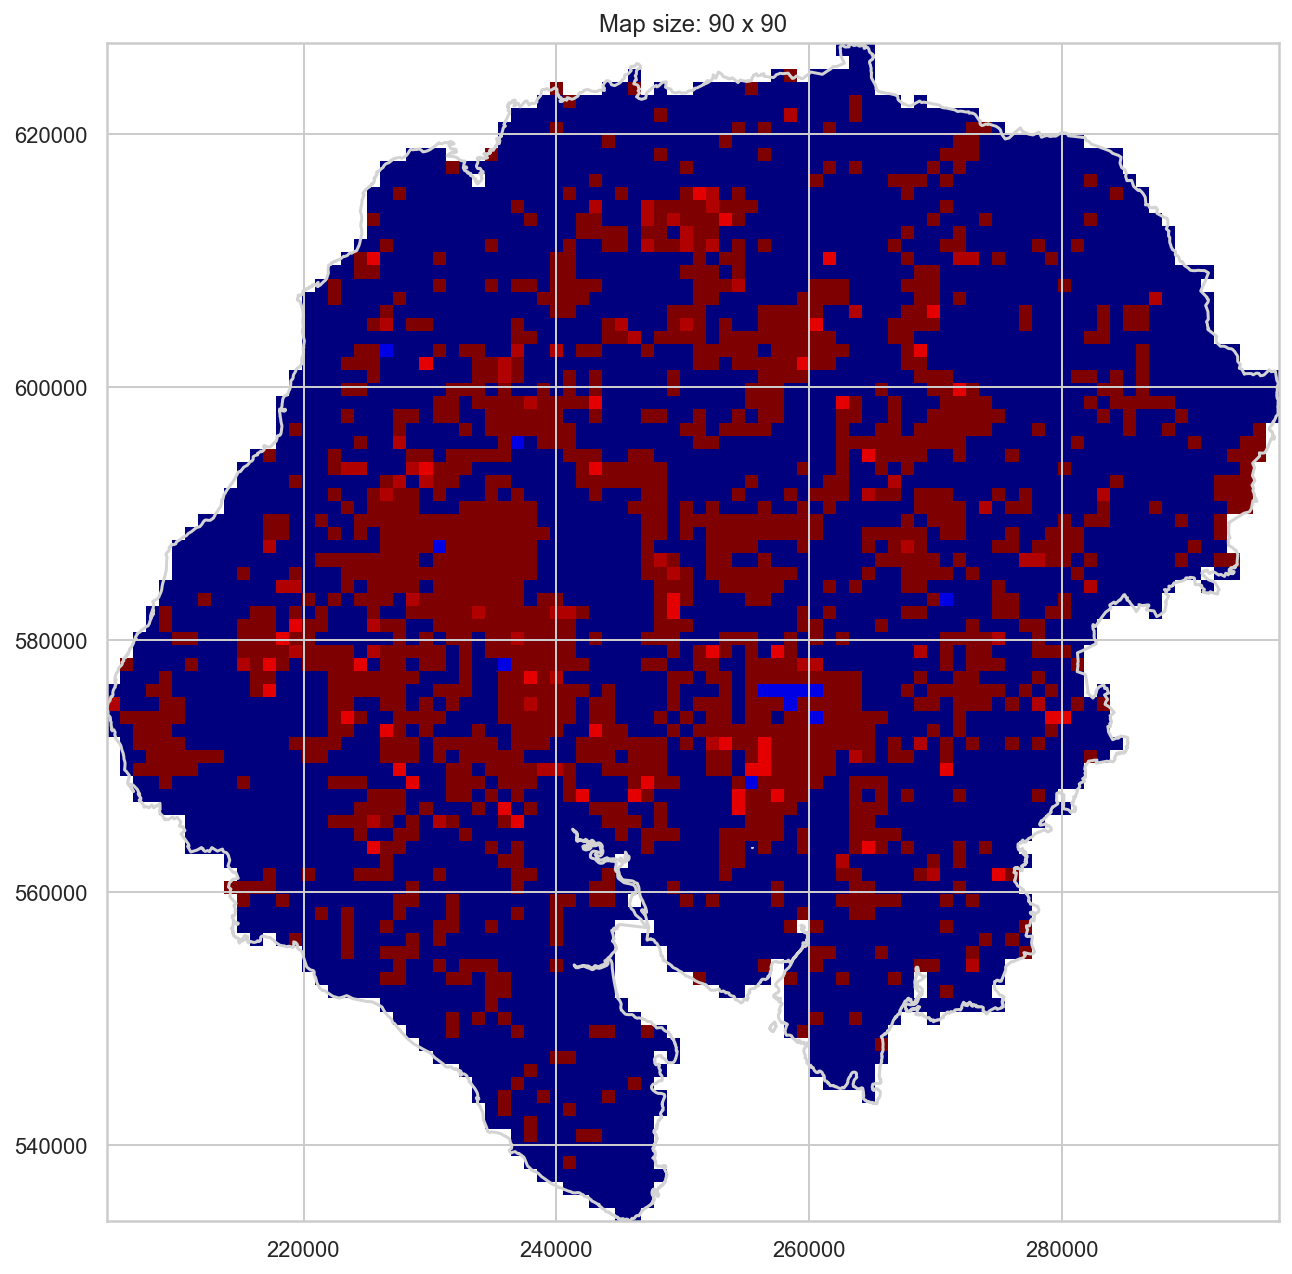

In [40]:
# 5) re-read the saved geotiff as a test and read the first layer of the map
src = rasterio.open(raster_fpath)
game_map = src.read(1, masked=True)

# 6) create a plot of the resulting map
fig, ax = plt.subplots()
show(game_map, ax=ax, transform=src.transform, cmap=cmap)
our_park_polygon.boundary.plot(ax=ax, color="lightgrey")
ax.set_title("Map size: {} x {}".format(rows, cols))
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "NFI_map_{}_{}_v2.png".format(rows, cols)),
    dpi=150,
    format="png"
)